# Analyze Code Quality using Pylint

In [25]:
import sqlite3
import pandas as pd
import os

db_path = "../../giicg.db"
if not os.path.exists(db_path):
    raise FileNotFoundError(f"Database file does not exist: {db_path}")

conn = sqlite3.connect(db_path)
code = pd.read_sql("SELECT * FROM translated_scratch_prompts_with_code", conn)
code = code.dropna(subset=['code'])
code = code[code['code'].str.strip() != '']
code = code.dropna(subset=['code'])
code = code[(code['gender'] == 'Woman (cisgender)') | (code['gender'] == 'Man (cisgender)')]
code = code[(code['programming_language'] == 'python')]

code

,code_reply_id,conversation_id,message_id,message_text,gender,user_id,model_reply,model_version,code,programming_language
0,1,6,5,I want to use Dummy Hot encoding to replace th...,Woman (cisgender),16,To perform **dummy hot encoding** (also called...,chatgpt-4o-latest,import pandas as pd\n\n# Sample DataFrame\ndf ...,python
2,3,8,47,I have a pandas dataframe like this:\ndata\tpe...,Woman (cisgender),28,Certainly! You can split the `persona` column ...,chatgpt-4o-latest,import pandas as pd\n\n# Sample DataFrame (rep...,python
4,5,12,65,Blender and Python. I have a collection of hun...,Man (cisgender),34,You can achieve this in **Blender (3.x or newe...,chatgpt-4o-latest,import bpy\nimport mathutils\n\n# === CONFIGUR...,python
5,6,13,126,"how to run a Python future without blocking, i...",Man (cisgender),46,"To run a Python coroutine or future ""non-block...",chatgpt-4o-latest,import asyncio\nfrom types import CoroutineTyp...,python
6,7,15,242,hey can you write me a short python script for...,Woman (cisgender),48,Certainly! Here's a short Python script you ca...,chatgpt-4o-latest,import pandas as pd\n\n# Load the CSV file\ndf...,python
...,...,...,...,...,...,...,...,...,...,...
169,170,66,1464,Please write down a jit-eable gradient of this...,Man (cisgender),77,Here's a JIT-able gradient function for `I_sq_...,claude-sonnet-4-20250514,"@jit\ndef grad_I_sq_IRD_res(t, s, k, kmax, eta...",python
170,171,70,1524,can you write a test that tests whether parse ...,Woman (cisgender),90,Here's a test that verifies the `parse_obj` fu...,claude-sonnet-4-20250514,import pytest\nfrom your_module import OdooTic...,python
171,172,72,1534,can you write me some python code to count the...,Woman (cisgender),11,Here are several ways to count objects in JSON...,claude-sonnet-4-20250514,import json\n\ndef count_json_items(json_data)...,python
172,173,74,1538,I want to merge these two dataframes: \ndf_tra...,Woman (cisgender),28,You can merge these two dataframes based on th...,claude-sonnet-4-20250514,import pandas as pd\n\n# Merge on 'claim' colu...,python


## Run pylint on all code blocks

In [26]:
import tempfile
import subprocess
def run_pylint_on_code(code):
    with tempfile.NamedTemporaryFile(mode='w', suffix='.py', delete=False) as tmp:
        tmp.write(code)
        tmp_path = tmp.name
    try:
        result = subprocess.run(
            ['pylint', '--score=y', '--output-format=text', '--rcfile=.pylintrc', tmp_path],
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            text=True
        )
        output = result.stdout
        errors = result.stderr
        # Extract score from output
        score_line = [line for line in output.split('\n') if 'Your code has been rated at' in line]
        if score_line:
            # Example: "Your code has been rated at 8.00/10"
            score = float(score_line[0].split(' ')[6].split('/')[0])
        else:
            score = None
        # Save the full pylint output and stderr (just in case)
        messages = output.strip() + '\n' + errors.strip()
    finally:
        os.remove(tmp_path)  # Always clean up
    return score, messages

In [27]:
from helpers.stats import run_t_test_on_gender
import matplotlib.pyplot as plt
plt.style.use('ggplot')

print("Running pylint on all code blocks...")
code['pylint_score'], code['pylint_messages'] = zip(*code.apply(lambda row: run_pylint_on_code(row['code']), axis=1))
code


Running pylint on all code blocks...


,code_reply_id,conversation_id,message_id,message_text,gender,user_id,model_reply,model_version,code,programming_language,pylint_score,pylint_messages
0,1,6,5,I want to use Dummy Hot encoding to replace th...,Woman (cisgender),16,To perform **dummy hot encoding** (also called...,chatgpt-4o-latest,import pandas as pd\n\n# Sample DataFrame\ndf ...,python,8.89,************* Module tmpsqo3hwb_\n/var/folders...
2,3,8,47,I have a pandas dataframe like this:\ndata\tpe...,Woman (cisgender),28,Certainly! You can split the `persona` column ...,chatgpt-4o-latest,import pandas as pd\n\n# Sample DataFrame (rep...,python,8.12,************* Module tmpw7ri4yaa\n/var/folders...
4,5,12,65,Blender and Python. I have a collection of hun...,Man (cisgender),34,You can achieve this in **Blender (3.x or newe...,chatgpt-4o-latest,import bpy\nimport mathutils\n\n# === CONFIGUR...,python,9.27,************* Module tmpce_6k9vz\n/var/folders...
5,6,13,126,"how to run a Python future without blocking, i...",Man (cisgender),46,"To run a Python coroutine or future ""non-block...",chatgpt-4o-latest,import asyncio\nfrom types import CoroutineTyp...,python,6.18,************* Module tmpnvj0ktye\n/var/folders...
6,7,15,242,hey can you write me a short python script for...,Woman (cisgender),48,Certainly! Here's a short Python script you ca...,chatgpt-4o-latest,import pandas as pd\n\n# Load the CSV file\ndf...,python,10.00,------------------------------------\nYour cod...
...,...,...,...,...,...,...,...,...,...,...,...,...
169,170,66,1464,Please write down a jit-eable gradient of this...,Man (cisgender),77,Here's a JIT-able gradient function for `I_sq_...,claude-sonnet-4-20250514,"@jit\ndef grad_I_sq_IRD_res(t, s, k, kmax, eta...",python,3.57,************* Module tmpvbrycdil\n/var/folders...
170,171,70,1524,can you write a test that tests whether parse ...,Woman (cisgender),90,Here's a test that verifies the `parse_obj` fu...,claude-sonnet-4-20250514,import pytest\nfrom your_module import OdooTic...,python,10.00,------------------------------------\nYour cod...
171,172,72,1534,can you write me some python code to count the...,Woman (cisgender),11,Here are several ways to count objects in JSON...,claude-sonnet-4-20250514,import json\n\ndef count_json_items(json_data)...,python,8.31,************* Module tmpzr_r51kc\n/var/folders...
172,173,74,1538,I want to merge these two dataframes: \ndf_tra...,Woman (cisgender),28,You can merge these two dataframes based on th...,claude-sonnet-4-20250514,import pandas as pd\n\n# Merge on 'claim' colu...,python,10.00,------------------------------------\nYour cod...


## Run Radon on all code blocks

In [29]:
from radon.complexity import cc_visit
from radon.metrics import mi_visit
from radon.raw import analyze
from radon.metrics import h_visit


def calc_radon_metrics(code):
    # Complexity
    try:
        complexity_data = cc_visit(code)
        cc_scores = [block.complexity for block in complexity_data] if complexity_data else [0]
        radon_complexity = float(sum(cc_scores) / len(cc_scores))
    except Exception:
        radon_complexity = None

    # MI index
    try:
        radon_maintainability_index = float(mi_visit(code, False))
    except Exception:
        radon_maintainability_index = None

    # Raw metrics
    try:
        raw = analyze(code)
        radon_loc = raw.loc
        radon_sloc = raw.sloc
        radon_lloc = raw.lloc
        radon_comments = raw.comments
    except Exception:
        radon_loc = radon_sloc = radon_lloc = radon_comments = None

    # Halstead metrics: volume, difficulty, effort, time required to program, bugs
    try:
        halstead = h_visit(code)
        if isinstance(halstead, dict):  # global scope
            h = halstead.get('<module>')
        else:
            h = None
        radon_volume = h.total.volume if h else None
        radon_difficulty = h.total.difficulty if h else None
        radon_effort = h.total.effort if h else None
        radon_trtp = h.total.time if h else None
        radon_bugs = h.total.bugs if h else None
    except Exception:
        radon_volume = radon_difficulty = radon_effort = radon_trtp = radon_bugs = None

    return (radon_complexity, radon_maintainability_index, radon_loc, radon_sloc, radon_lloc, radon_comments,
            radon_volume, radon_difficulty, radon_effort, radon_trtp, radon_bugs)


print("Running radon analysis on all code blocks...")
metrics = code['code'].apply(calc_radon_metrics)
columns = ['radon_complexity', 'radon_maintainability_index',
           'radon_loc', 'radon_sloc', 'radon_lloc', 'radon_comments',
           'radon_volume', 'radon_difficulty', 'radon_effort', 'radon_trtp', 'radon_bugs']
for idx, col in enumerate(columns):
    code[col] = metrics.apply(lambda vals: vals[idx])
code

Running radon analysis on all code blocks...


,code_reply_id,conversation_id,message_id,message_text,gender,user_id,model_reply,model_version,code,programming_language,...,radon_maintainability_index,radon_loc,radon_sloc,radon_lloc,radon_comments,radon_volume,radon_difficulty,radon_effort,radon_trtp,radon_bugs
0,1,6,5,I want to use Dummy Hot encoding to replace th...,Woman (cisgender),16,To perform **dummy hot encoding** (also called...,chatgpt-4o-latest,import pandas as pd\n\n# Sample DataFrame\ndf ...,python,...,100.000000,22,11,10,6,None,None,None,None,None
2,3,8,47,I have a pandas dataframe like this:\ndata\tpe...,Woman (cisgender),28,Certainly! You can split the `persona` column ...,chatgpt-4o-latest,import pandas as pd\n\n# Sample DataFrame (rep...,python,...,97.689684,30,16,16,9,None,None,None,None,None
4,5,12,65,Blender and Python. I have a collection of hun...,Man (cisgender),34,You can achieve this in **Blender (3.x or newe...,chatgpt-4o-latest,import bpy\nimport mathutils\n\n# === CONFIGUR...,python,...,76.841606,66,42,42,12,None,None,None,None,None
5,6,13,126,"how to run a Python future without blocking, i...",Man (cisgender),46,"To run a Python coroutine or future ""non-block...",chatgpt-4o-latest,import asyncio\nfrom types import CoroutineTyp...,python,...,82.128506,46,37,37,10,None,None,None,None,None
6,7,15,242,hey can you write me a short python script for...,Woman (cisgender),48,Certainly! Here's a short Python script you ca...,chatgpt-4o-latest,import pandas as pd\n\n# Load the CSV file\ndf...,python,...,100.000000,14,6,7,4,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,170,66,1464,Please write down a jit-eable gradient of this...,Man (cisgender),77,Here's a JIT-able gradient function for `I_sq_...,claude-sonnet-4-20250514,"@jit\ndef grad_I_sq_IRD_res(t, s, k, kmax, eta...",python,...,83.646528,55,15,16,11,None,None,None,None,None
170,171,70,1524,can you write a test that tests whether parse ...,Woman (cisgender),90,Here's a test that verifies the `parse_obj` fu...,claude-sonnet-4-20250514,import pytest\nfrom your_module import OdooTic...,python,...,76.041210,73,53,33,13,None,None,None,None,None
171,172,72,1534,can you write me some python code to count the...,Woman (cisgender),11,Here are several ways to count objects in JSON...,claude-sonnet-4-20250514,import json\n\ndef count_json_items(json_data)...,python,...,63.070999,112,88,65,10,None,None,None,None,None
172,173,74,1538,I want to merge these two dataframes: \ndf_tra...,Woman (cisgender),28,You can merge these two dataframes based on th...,claude-sonnet-4-20250514,import pandas as pd\n\n# Merge on 'claim' colu...,python,...,100.000000,17,11,11,5,None,None,None,None,None


In [30]:
print(calc_radon_metrics("""def process_dataframe():
    import pandas as pd
    df = pd.DataFrame({'embarked': ['C','Q','S','S','C']})
    from sklearn.preprocessing import OneHotEncoder
    encoder = OneHotEncoder(sparse=False, drop=None)
    encoded = encoder.fit_transform(df[['embarked']])
    encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(['embarked']))
    df_encoded = df.join(encoded_df)
    print(df_encoded)
    encoder = OneHotEncoder(sparse=False, drop='first')
"""))

(1.0, 100.0, 10, 10, 11, 0, None, None, None, None, None)


## Save to database

In [31]:
code.to_sql("pylint_scores", conn, if_exists="replace", index=False)

144

In [40]:

print("Average pylint score (Female):", code[code['gender'] == 'Woman (cisgender)']['pylint_score'].mean())
print("Average pylint score (Male):", code[code['gender'] == 'Man (cisgender)']['pylint_score'].mean())

def t_test(df, col):
    print(f"\nComparing {col}")
    for model in df['model_version'].unique():
        model_df = df[df['model_version'] == model]
        women_scores = model_df[model_df['gender'] == 'Woman (cisgender)'][col].dropna()
        men_scores = model_df[model_df['gender'] == 'Man (cisgender)'][col].dropna()
        if len(women_scores) < 2 or len(men_scores) < 2:
            print(f"\nModel: {model} - Not enough data for t-test")
            continue
        if women_scores.nunique() < 2 and men_scores.nunique() < 2:
            print(f"\nModel: {model} - No variance in both groups")
            continue
        from scipy import stats
        t_stat, p_value = stats.ttest_ind(men_scores, women_scores, equal_var=False)
        print(f"\nModel: {model} - T-statistic: {t_stat}, p-value: {p_value}, n women: {len(women_scores)}, n men: {len(men_scores)}")

t_test(code, "pylint_score")
t_test(code, "radon_complexity")
t_test(code, "radon_maintainability_index")




Average pylint score (Female): 8.192954545454546
Average pylint score (Male): 6.895909090909091

Comparing pylint_score

Model: chatgpt-4o-latest - T-statistic: -0.7180868721547953, p-value: 0.48434584311311835, n women: 14, n men: 8

Model: o3-2025-04-16 - T-statistic: -0.6524916529894466, p-value: 0.5340831181157556, n women: 9, n men: 7

Model: gpt-5-chat-latest - T-statistic: -1.3890113146754481, p-value: 0.2087034897199314, n women: 15, n men: 7

Model: gpt-4.1-2025-04-14 - T-statistic: -1.1688590908884786, p-value: 0.2799770093004341, n women: 14, n men: 7

Model: gpt-4o-2024-08-06 - T-statistic: -0.742467603164487, p-value: 0.47180835693997847, n women: 12, n men: 7

Model: claude-3-7-sonnet-20250219 - T-statistic: -1.597730988354998, p-value: 0.17448595060584882, n women: 12, n men: 5

Model: claude-sonnet-4-20250514 - T-statistic: -0.9466286093155705, p-value: 0.4066316074844795, n women: 12, n men: 3

Comparing radon_complexity

Model: chatgpt-4o-latest - T-statistic: 1.02446

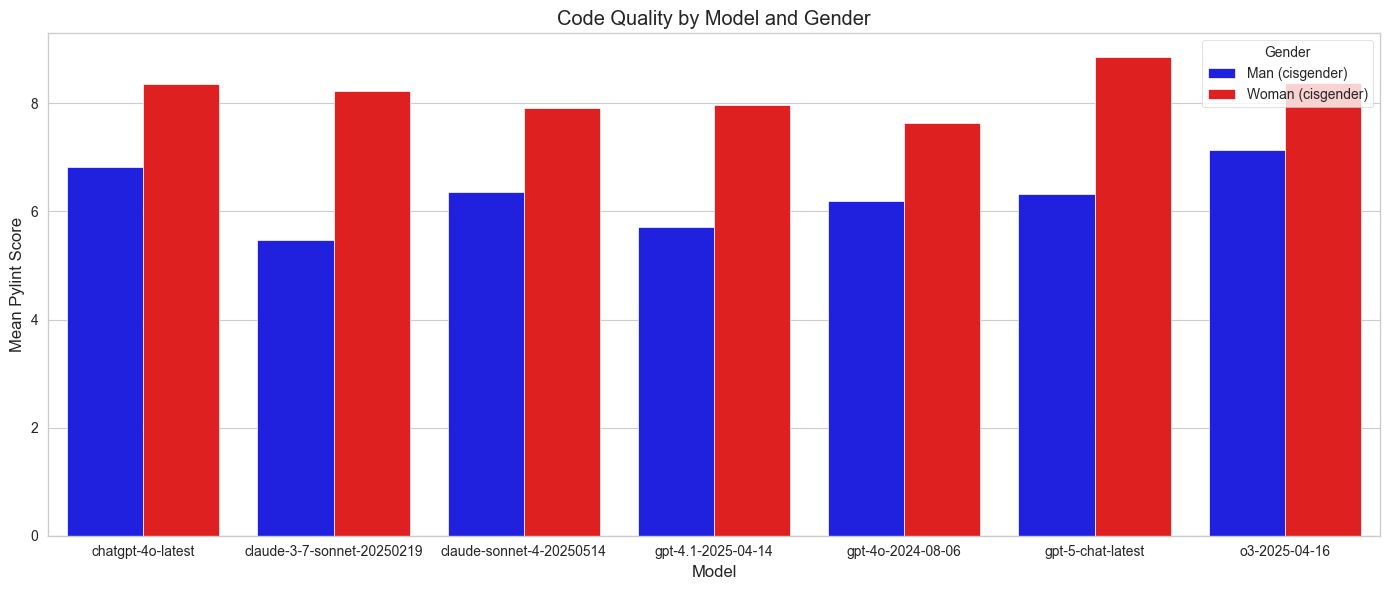

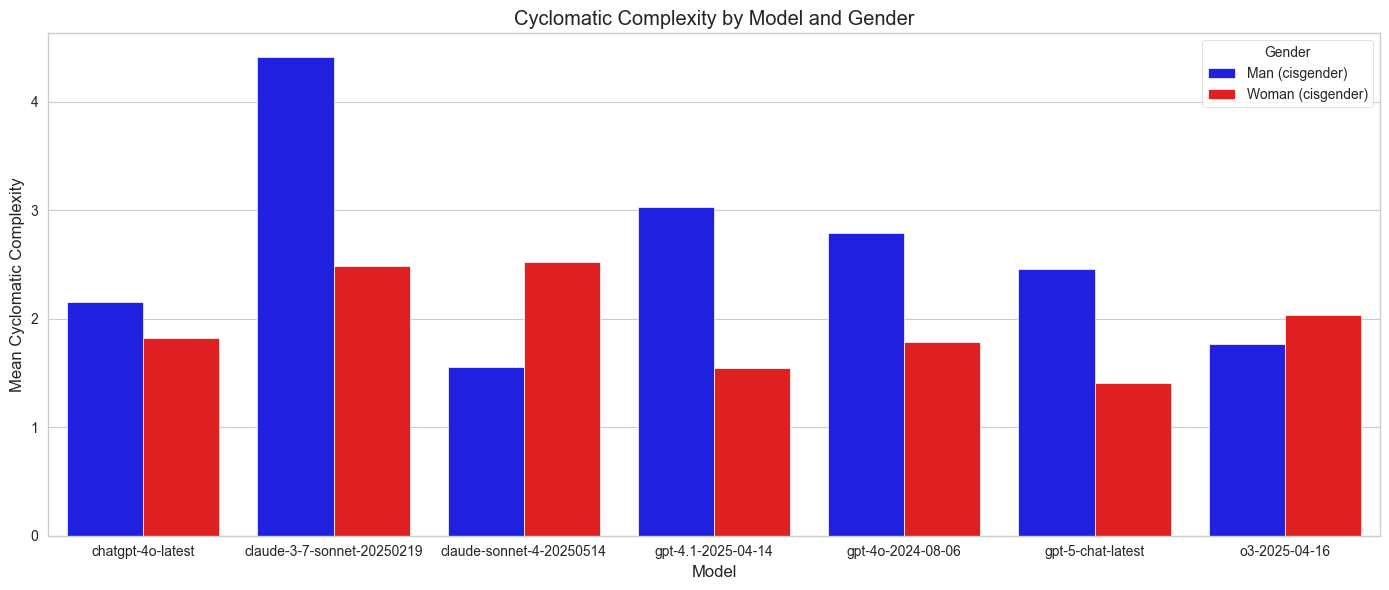

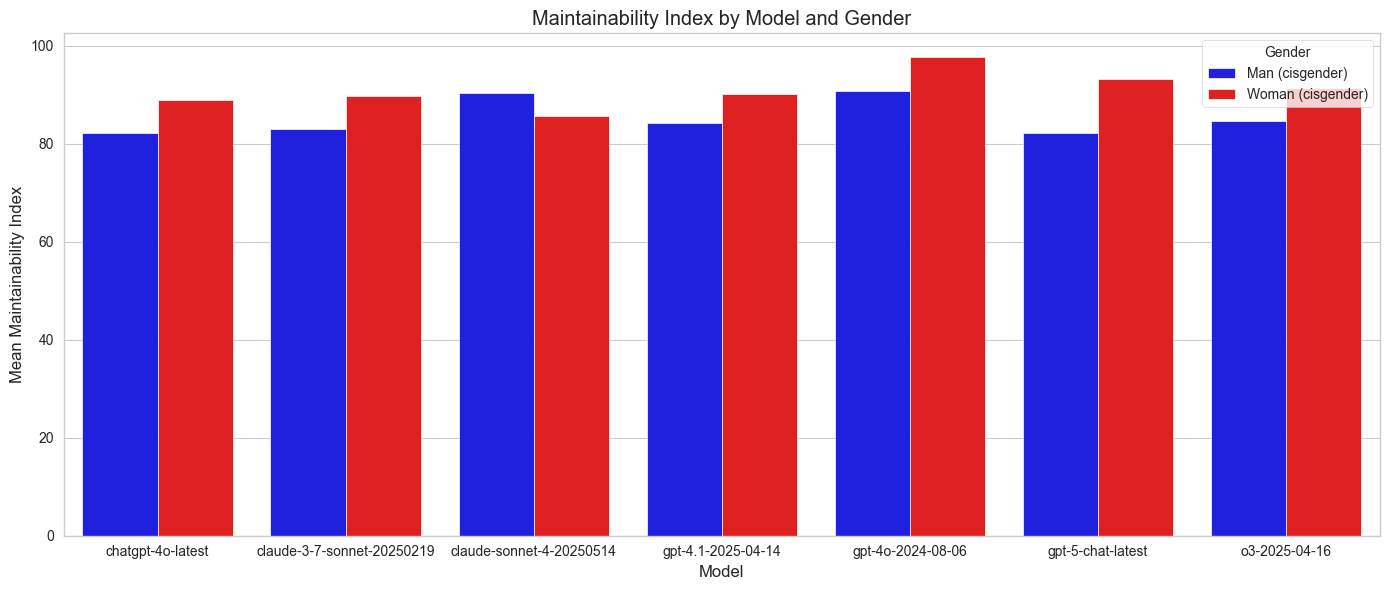

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Average pylint score per user, model and gender
user_avg = (
    code.groupby(['model_version', 'user_id', 'gender'])['pylint_score']
    .mean()
    .reset_index()
)

# 2. Compute mean per model and gender
plot_df = (
    user_avg.groupby(['model_version', 'gender'])['pylint_score']
    .mean()
    .reset_index()
)

# 3. Plot!
plt.figure(figsize=(14, 6))
sns.set_style("whitegrid")
bar = sns.barplot(
    data=plot_df,
    x='model_version',
    y='pylint_score',
    hue='gender',
    palette={'Woman (cisgender)':'red', 'Man (cisgender)':'blue'}
)

plt.xlabel('Model')
plt.ylabel('Mean Pylint Score')
plt.title('Code Quality by Model and Gender')
plt.legend(title='Gender')
plt.tight_layout()
plt.show()


# --- Plot Radon Cyclomatic Complexity ---

# Per-user, per-model, per-gender average
user_avg_complexity = (
    code.groupby(['model_version', 'user_id', 'gender'])['radon_complexity']
    .mean()
    .reset_index()
)

# Mean per model and gender
plot_df_complexity = (
    user_avg_complexity.groupby(['model_version', 'gender'])['radon_complexity']
    .mean()
    .reset_index()
)

plt.figure(figsize=(14, 6))
sns.set_style("whitegrid")
bar = sns.barplot(
    data=plot_df_complexity,
    x='model_version',
    y='radon_complexity',
    hue='gender',
    palette={'Woman (cisgender)':'red', 'Man (cisgender)':'blue'}
)
plt.xlabel('Model')
plt.ylabel('Mean Cyclomatic Complexity')
plt.title('Cyclomatic Complexity by Model and Gender')
plt.legend(title='Gender')
plt.tight_layout()
plt.show()


# --- Plot Radon Maintainability Index ---

user_avg_mi = (
    code.groupby(['model_version', 'user_id', 'gender'])['radon_maintainability_index']
    .mean()
    .reset_index()
)

plot_df_mi = (
    user_avg_mi.groupby(['model_version', 'gender'])['radon_maintainability_index']
    .mean()
    .reset_index()
)

plt.figure(figsize=(14, 6))
sns.set_style("whitegrid")
bar = sns.barplot(
    data=plot_df_mi,
    x='model_version',
    y='radon_maintainability_index',
    hue='gender',
    palette={'Woman (cisgender)':'red', 'Man (cisgender)':'blue'}
)
plt.xlabel('Model')
plt.ylabel('Mean Maintainability Index')
plt.title('Maintainability Index by Model and Gender')
plt.legend(title='Gender')
plt.tight_layout()
plt.show()
